In [6]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# 多行输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# 精调通用语言模型用于文本分类
- [fastai/ULMFit.ipynb at master · fastai/fastai](https://github.com/fastai/fastai/blob/master/examples/ULMFit.ipynb)

- 文本预处理做的比较糙，繁体简体咩有考虑

In [70]:
from fastai import *
from fastai.text import *
from fastai.core import *
from sklearn.metrics import f1_score

- 基于中文维基百科训练

In [8]:
bs = 64
lang = 'zh'

In [9]:
data_path = Config.data_path()
data_path

PosixPath('/home/lab/.fastai/data')

- 提取TXT文件放在 docs 文件夹下

In [10]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
dest = path/'docs'
lm_fns_bwd = [f'{lang}_wt_bwd', f'{lang}_wt_vocab_bwd']

- 下载的文件为 xml 格式
- 大概有 46480 词目

- 提取信息

In [11]:
path.ls()

[PosixPath('/home/lab/.fastai/data/zhwiki/log'),
 PosixPath('/home/lab/.fastai/data/zhwiki/train.csv'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zhwiki'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zh_textlist_class'),
 PosixPath('/home/lab/.fastai/data/zhwiki/models'),
 PosixPath('/home/lab/.fastai/data/zhwiki/docs'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zhwiki-latest-pages-articles.xml'),
 PosixPath('/home/lab/.fastai/data/zhwiki/val.csv'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zh_databunch'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zhwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/lab/.fastai/data/zhwiki/wikiextractor')]

### 创建数据
- 先运行 forward
- 先加载 forward 数据做个对比
- 创建 backward 数据
- backward模型
- 集成

- token和数值

In [12]:
data = load_data(path, f'{lang}_databunch', bs=bs)

In [13]:
data.show_batch()

idx,text
0,xxmaj junior xxunk xxmaj junior xxunk xxmaj xxunk 。 \n \n xxunk xxunk xxmaj lasting xxmaj xxunk 。 \n \n xxunk xxunk 。 \n \n xxunk 。 \n \n xxunk xxunk xxmaj junior xxmaj kiss xxmaj the xxunk 。 \n \n xxunk xxunk xxunk 。 \n \n xxunk xxmaj junior xxmaj kiss xxmaj the xxmaj xxunk 。 \n \n xxunk xxunk xxunk 。
1,xxunk - xxunk - xxunk 。 \n \n xxunk - xxunk 。 \n \n xxunk 。 \n \n xxunk 。 \n \n xxunk 。 \n \n xxunk 。 \n \n xxunk / xxunk / xxunk / xxunk / xxunk 。 \n \n xxunk - xxunk 。 \n \n xxunk 。 \n \n xxunk 。 \n \n xxunk 。 \n \n
2,\n \n xxunk 。 \n \n xxup xxunk / xxup xxunk / xxup xxunk / xxunk 。 \n \n xxunk / xxup xxunk / xxup xxunk / xxup xxunk / xxup xxunk / xxup xxunk / xxup xxunk - xxup xxunk - xxup xxunk - xxunk 。 \n \n xxunk 。 \n \n xxunk 。 \n \n xxunk xxrep 4 、 xxunk 。 \n
3,。 ” \n \n 《 xxunk 。 ” \n \n 《 xxunk 。 ” \n \n xxunk 》 ） \n \n 《 xxunk 。 ” \n \n xxunk 》 ） \n \n 《 xxunk … … xxunk … … xxunk ） 。 \n \n xxunk 》 ） \n \n xxunk 》 ） \n \n xxunk 》 ） \n \n xxunk
4,。 \n \n xxunk 。 \n \n xxunk ： \n \n xxunk 。 \n \n xxunk ： \n \n formula_4 \n \n xxunk \n xxunk 。 \n \n xxunk xxunk ： \n \n formula_13 \n \n xxunk ： \n \n xxunk 。 \n \n xxunk \n \n xxunk \n \n xxunk \n \n xxunk \n


In [16]:
data_bwd = load_data(dest, f'{lang}_databunch_bwd', bs=bs, backwards=True)

In [17]:
data_bwd.show_batch()

idx,text
0,\n \n \n \n \n \n \n \n 。 xxunk \n \n 。 xxunk xxup \n \n 。 xxunk xxup \n \n 。 xxunk / xxunk xxup \n \n 。 xxunk \n \n 。 xxunk xxup \n \n 。 xxunk \n \n 。 xxunk \n \n 。 xxunk \n \n 。 xxunk \n \n 。 xxunk \n \n
1,xxmaj xxunk xxunk san xxmaj of xxunk xxunk xxmaj xxunk xxunk xxunk xxmaj xxunk de bautista xxmaj xxunk de gaspar xxmaj xxunk \n \n 。 xxunk \n \n 。 xxunk - xxunk - xxunk \n \n 。 xxunk / xxunk \n \n 。 xxunk \n \n 。 」 xxunk \n 。 xxunk \n \n 。 ） （ 」 xxunk \n \n 。
2,。 xxunk \n \n 。 xxunk xxmaj xxunk \n \n 。 xxunk \n \n ” 。 xxunk \n \n 。 xxunk xxmaj xxunk \n \n 。 xxunk xxmaj xxunk xxmaj xxunk \n \n 。 xxunk \n \n 。 xxunk xxmaj xxunk \n \n 。 xxunk \n \n ” 。 xxunk \n \n 。 」 xxunk xxmaj xxunk \n \n
3,; 》 : cn - zh > = 〉 ; 》 : hans - xxunk - zh > = 〈 ; 《 : cn - zh > = 〈 ; 《 : hans - xxunk \n \n xxunk xxbos \n > doc / < \n \n \n \n 。 xxunk \n \n 。 xxunk xxmaj xxunk \n \n ） basin xxunk （ xxunk xxmaj xxunk
4,"。 xxunk \n \n 。 xxunk \n \n 。 xxunk xxup , boundary growth urban ( 」 xxunk \n \n 。 xxunk \n \n 。 % xxunk \n \n 。 xxunk \n \n 。 xxunk \n \n 。 xxunk \n \n 。 xxunk ° xxunk ° xxunk \n \n 。 xxunk \n \n 。 xxunk \n \n 。 xxunk"


- 数据对比

In [20]:
x, y = data.train_ds[0]
x1, y1 = data_bwd.train_ds[0]

In [25]:
x == x1

True

- 模型配置

In [28]:
awd_lstm_lm_config

{'emb_sz': 400,
 'n_hid': 1152,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': False,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

- 不使用预训练权重，我们从头训练，使用中文维基百科

In [39]:
learn = language_model_learner(data_bwd, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


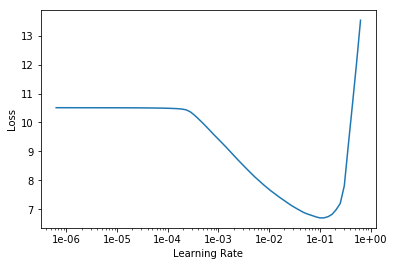

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
lr = 1e-2
lr *= bs/48  # Scale learning rate by batch size
# 所有层都是可以训练的
learn.unfreeze()

In [42]:
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.944244,1.763525,0.674630,05:50
1,1.773503,1.668512,0.680306,05:51
2,1.766582,1.624066,0.685923,05:51
3,1.641661,1.605911,0.688057,05:50
4,1.734819,1.585995,0.689517,05:50
5,1.663317,1.569859,0.692416,05:50
6,1.549388,1.553046,0.695026,05:50
7,1.562497,1.537944,0.696345,05:51
8,1.598402,1.531919,0.697588,05:51
9,1.475013,1.531701,0.697916,05:51


- 保存模型权重与字典

In [43]:
path.ls()

[PosixPath('/home/lab/.fastai/data/zhwiki/log'),
 PosixPath('/home/lab/.fastai/data/zhwiki/train.csv'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zhwiki'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zh_textlist_class'),
 PosixPath('/home/lab/.fastai/data/zhwiki/models'),
 PosixPath('/home/lab/.fastai/data/zhwiki/docs'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zhwiki-latest-pages-articles.xml'),
 PosixPath('/home/lab/.fastai/data/zhwiki/val.csv'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zh_databunch'),
 PosixPath('/home/lab/.fastai/data/zhwiki/zhwiki-latest-pages-articles.xml.bz2'),
 PosixPath('/home/lab/.fastai/data/zhwiki/wikiextractor')]

In [44]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns_bwd[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns_bwd[1] + '.pkl'))

In [45]:
TEXT = "中国"
N_WORDS = 40
N_SENTENCES = 2

In [46]:
print("\n\n".join(learn.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

中国 > doc / < 
 
 
 
  。 ” “ ： 》 side The " 
 
  。 ” 》 《 》 《 （ 」 。 》 《 、 》 《 ： 
 
  。 》 《 ： 》 《 、 》

中国 > doc / < 
 
 
  。 ” ” 。 』 ？ ！ 」 ？ ！ ！ ！ ？ ？ 』 ？ 。 。 ’ ） （ ？ ！ … … review Sales File Groove The


### 进行语义分析任务backward
- 参看 [中文数据集](BERT.ipynb)

In [47]:
data_lm_bwd = load_data(f'{lang}_clas_databunch', bs=bs, backward=True)

In [54]:
data_lm_bwd.show_batch()

idx,text
0,"xxunk xxbos xxunk xxbos xxunk xxrep xxunk 。 xxbos 虽说合肥的酒店及服务比较差能理解,但没见过这么差的服务及酒店设施!还四星级呢,简直不如街边的小旅馆!服务员前台和大堂经理的素质特低!房间简直就是垃圾房拼的,而且酒店还说通过携程订的房间就是这种房,而且还是最差的,要么就在酒店前台订,房价一样房间却要好很多 xxrep 7 . 晕!强烈谴责此酒店的做法!坚决不会再入住该酒店!火车站旁边有个邮政宾馆还可以 xxbos 10月25日入住单人大床间一晚,感觉较差:1.晚上22:30左右入住,前台接待很冷淡,无笑容,感觉不亲切;2.最可怕的是冲澡3分钟后淋浴龙头停水,2分钟以后浴缸龙头也完全停水.没办法浴室内打电话给大堂,说派人上来看一下,这时发现房间内未配浴袍.后大堂副理上来,告诉也有其它房间有类似情况,因最近酒店附近管理维修.只是建议给换房间 xxbos 头两晚入住单间,窗式空调以及窗外传来的噪音让人无法入睡。查因房间唯一的窗户外是两栋大厦的夹缝,宽约两米,而两栋大厦的所有空调机都安装于此,可想而知同时启动的噪音有多么的轰动.但正值元旦假期,只能屈就.第三天转为双人间,犹如从地狱转往天堂,空调是分体的,远离夹缝,面积大两倍,还可远眺香港城貌,房价只交多100元.建议有意入住该酒店的朋友哪怕一个人也选择双人间,这里的地理位置实在棒极了. xxbos 优点就是地理位置，到外滩和南京路走路10分钟。房间比较小，楼层举架低，有点压抑。卫生间毛巾也许消过毒，但很旧，颜色发黄，没办法，我用的自带毛巾。服务人员都不太热情，办理入住的女孩子们还好，大堂前的服务生，问个路什么的回答问题时基本不正眼看我，很锻炼我的脾气，有利于修身养性 。 xxbos xxunk xxbos xxunk ！ xxbos xxunk / xxunk 。 xxbos xxunk 。 xxbos xxup xxunk ！ xxbos xxunk 。 xxbos xxunk 。 xxbos xxunk 。 。 。 xxbos 一个词 xxrep 4 - "" 大失所望""!!!去广州之前,在携程上研究了半天,后来应老公的要求选择了elan,因为他从欧洲带过来的那本""china xxrep 4 - lonelyplanet""上极尽完美之辞的推荐了该酒店.网上看图片和介绍,觉得应该也不错(没有查点评),我当时认为应该和""有一家""的水平差不多.可是一进房间,发现和图片实在相差太远.房间小得可怜,没有地方放行李,甚至连坐的地方都没有.一张小得可怜的写字台上有一台小得可怜的""液晶电视"".如果你想躺在床上看电视,恐怕需要一双""千里眼"";如果你想使用那张写字台,那你一定需要很苗条,才能坐在那个位置,并且需要带一台小于12寸的笔记本，否则是放不下的.房间也不干净,首先进去的那间330元的大床房,马桶里居然还漂着头发.后来立马换了间560元的套房,其实也就稍微大一点点,多了个坐的地方,有沙发和桌子及大一点的普通电视.房间设施很陈旧,地板有些地方已经翘起来了,隔音不好,热水水压也不够 xxrep 5 . 前台服务还不错,服务员能说英语;但是压根没见到行李生.个人感觉,不值那个价钱;个人意见,不推荐入住 ! xxbos xxunk 。 xxbos xxunk"
1,4 . xxunk xxrep 4 . xxunk xxrep 5 . xxbos xxunk 。 xxbos 很老的酒店，箱柜旧的都没法看了，前台服务跟门童都值得夸奖。不然真的是一无是处了。270的价格让人诧异，有点疯。不会再去了 。 xxbos xxunk ！ xxbos xxunk ！ xxbos xxunk xxrep 8 ！ xxunk ！ xxbos 隔音效果非常非常非常的差，睡在房间里象睡在马路边一样，路上声音听的清清楚楚。我还是看了携程上该酒店的点评，采纳网友意见预定了5楼以上的房间。结果还是非常的吵，到晚上12点还是睡不着，只好打开电视以掩盖马路上的车声。不知道几点睡着了，一大早就被车声吵醒，一看表，才早上4点！才4点啊，也就是说就算晚上12点我睡着了，也才睡了4个小时。头疼啊，白天还要工作啊，闭上眼睛努力睡，怎么样也睡不着啊，太吵了。坚持到5：30实在是受不了了，打电话给前台，问有没有安静点的房间可以换，现在不能换晚上换也可以，答曰：没有。盯着天花板熬到6：30，起床。在早餐厅灌了3杯咖啡后，马上去退房。本来是要住三天的，实在是受不了这个吵啊。真不明白这样差的条件怎么在携程上有4.0的评分。另：1.电视播放太复杂，不方便2.服务员服务意识不强，没有为客人着想、以解决问题为本的意识。体现在早餐券、开发票等问题上3、网线太短，大概就20厘米长吧，不能在床上上网4.电源接触不好，电脑电源连到插座上时火花噼里啪啦的冒，当时我想：因为电源问题损坏电脑不知道酒店赔不赔再次表示疑问：这样的酒店上怎么会有4、0的高分数，宾馆反馈2008年3月30日：首先感谢您的入住并提出宝贵的意见，由于房间的环境问题影响到您的休息为此我们深表歉意。对于您提出的一些问题，我们会酌情整改，另外酒店早餐是凭房卡用的，没有早餐券；我们客房中心随时都为一些有特殊要求的客人准备了较长的网线，如果有需要只要一个电话，马上送到房间。非常感谢您的宝贵意见，真诚期待您能再次光临，给我们一个能为您提供更好服务的机会 。 xxbos xxunk ! xxbos xxunk 。 xxbos xxunk xxbos xxunk / xxunk / xxunk xxbos 好小的门面，没有电梯，房间也不是很一致！豪华房居然要400多，马桶还是坏的！酒店太自作主张了 xxrep 4 。 xxbos xxunk ! xxbos xxunk 。 xxbos 好小的门面，没有电梯，房间也不是很一致！最郁闷的是我不知道我们公司跟他们有合约，他就让我的客人（另外一次）直接用我们公司的名义住的酒店，而没有通过ctrip。还好第二天ctrip打电话给我确认，让我退单了 。 xxbos xxunk 。 xxbos xxunk 。 xxbos xxunk 。 xxbos
2,"。 xxbos xxunk xxbos xxunk 。 xxbos 入住当晚,因火车到达得较晚。到酒店前门一看，感觉就象烂尾楼，黑灯瞎火的，还以为出租车拉错地方了。后面到总台一问说是大堂搞装修。上到房间一看，房间内的设置就更差了。地毯上到处是补丁，一股子霉味，我住的还是豪华标双。不晓得普标哪得成什么样？两百多人民币还不如现如今的经济型酒店，太失望了，货不对板(跟图片上比）。宾馆反馈2008年5月30日：谢谢您的宝贵意见!实在对不起,我代表酒店向您致以诚挚的歉意!您提的这几个问题酒店现在已经全部解决,欢迎您下次入住 ! xxbos 酒店房间太烂。服务一般。地点也差。房间小，卫生间小，居然还是蹲便 。 。 。 xxbos xxunk ！ xxbos xxunk xxrep 8 ！ xxunk xxrep 6 ！ xxbos xxunk 。 xxbos 房间还可以,设施简单,不像是四星标准。早餐还算丰富,不过要早去。前台接待、结算速度和态度还不错。后院停车场很有特点，一晚上有两台车被划伤，真恐怖，最关键的是保安及小头目还不想认帐，气愤啊 xxbos xxunk 。 xxbos 订的豪华标间，738元的价格，住过的同等对比是最差的。周边环境除了一地铁口没有其它，餐厅不行，周边也找不着吃的。房间小，住了两天还有一天晚上没水，宽带收费40，打印贡献了几十个10元。绝对不值 。 xxbos xxup 388元的房间,也就值248元.上网居然收费且人工配制ip.打死也不再住. xxbos xxunk ! xxbos xxunk xxbos 房间巨小，电视成了摆设，开不了，服务员态度冷漠。以后不会再进这家酒店 xxbos xxunk xxbos 请各位注意酒店提供的饮用水是自来水，这是前台服务员说的。所以各位千万不能生喝酒店提供的饮用水。2008年了，北京的酒店还是这种水平，真是令人心寒 。 xxbos 1 \ xxunk \ xxunk \ xxunk \ xxunk xxbos 酒店比较旧，听说有十几年的历史，房间也比较小。一个所谓三星酒店连一次性的剃须刀都不提供，要另外花15块钱买。总体上还不如火车站周边的商务酒店 。 xxbos xxunk 。 xxbos 临近道路边,相当的吵,隔音效果差"
3,"- xxunk xxrep 4 . xxunk xxrep 4 . xxup xxunk 。 xxbos xxunk xxbos 根本就是家庭旅馆 .. 还298 + 12基金 ... 我去的时候刚好是国庆他们说在装修,把我安排在前面的民宅一样的地方 .. 刚开始带我去6号楼，妈的根本不是人住的破 .. 然后把我带回8号楼.大一点 .. 而且这个地方离海很远,,到的晚上说明天会用车送我们到海边,第2天下大雨,说车不在，我朋友和他交涉,旅游的心情都被影响 ... 被ctrip的照片骗了 .. 这个破旅馆真的不是人住的!!以后再也不图便宜了!!补充点评2007年10月11日：298的房间ctrip上标有""宽带免费"" .. 可那里根本不能上网 .. 我带的那么重的电脑就白拿了 .. 我有被骗的感觉 ! ! xxbos xxunk ! xxbos xxup 9月9日入住,从小事即可见一斑：浴帘比浴盆高200毫米，弄得卫生间一地水，功能丧失，不如说是遮羞布；餐厅桌布油迹斑斑，服务员总

### 使用我们之前训练的模型学习一个语言模型

- `pretrained_fnames=lm_fns`

In [55]:
lm_fns

['zh_wt', 'zh_wt_vocab']

In [56]:
learn_lm = language_model_learner(data_lm_bwd, AWD_LSTM, pretrained_fnames=lm_fns_bwd, wd=0.1, drop_mult=1.)

In [57]:
lr = 1e-3
lr *= bs/48

In [58]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.697358,5.175411,0.212500,00:00
1,6.201413,4.778626,0.230804,00:00


In [59]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.548280,4.604518,0.240179,00:00
1,5.249329,3.720865,0.347321,00:00
2,4.763565,2.581959,0.468304,00:00
3,4.259766,2.183122,0.579241,00:00
4,3.877409,2.004621,0.593750,00:00
5,3.585753,1.897657,0.604911,00:00
6,3.358438,1.860995,0.610045,00:00
7,3.205450,1.840042,0.615848,00:00


In [60]:
learn_lm.save(f'{lang}fine_tuned_bwd')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_bwd')

In [61]:
TEXT = '我喜欢'

In [62]:
print("\n\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.9) for _ in range(N_SENTENCES)))

我喜欢 > xxbos . > xxbos 。 xxbos ) xxbos / xxbos 。 > / / ( - : . 10 . ) ( ! ! ! ! ! ! ! ! xxbos . ! xxbos

我喜欢 / - ! ! 9 ! ! ! ! ! ! xxbos , * 5 ? ? ! 4 ! 4 ? ! 4 ! ! 12 ..... !!!!! !!!!! !!!!! !!!!! !!!!! xxbosxxbosxxbosxxbosxxbos


In [63]:
len(data_lm.train_ds)

9000

### 分类

In [65]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=4, backward=True)

In [66]:
@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [67]:
learn_c = text_classifier_learner(data_clas_bwd, AWD_LSTM, pretrained=False, drop_mult=0.5, metrics=[f1, accuracy], wd=0.1).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_bwd')
learn_c.freeze()

In [68]:
lr=2e-2
lr *= bs/48

In [71]:
learn_c.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.477027,0.522003,0.737219,0.745556,00:01
1,0.485022,0.495955,0.741332,0.751111,00:01
2,0.493099,0.518831,0.710202,0.737778,00:01
3,0.484330,0.494661,0.752563,0.754444,00:01
4,0.483695,0.509657,0.745997,0.745556,00:01
5,0.481792,0.494413,0.743542,0.748889,00:01
6,0.468664,0.899974,0.735527,0.748889,00:01
7,0.472452,0.513543,0.745006,0.751111,00:01


/home/lab/Softwares/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.481273,0.493253,0.769983,0.750000,00:01
1,0.479506,0.586876,0.763711,0.740000,00:01
2,0.471515,0.503489,0.751259,0.748889,00:01


In [73]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.485243,0.508445,0.761227,0.744444,00:02
1,0.473014,0.498693,0.757239,0.753333,00:02
2,0.470699,0.495109,0.762190,0.747778,00:02


In [74]:
learn_c.unfreeze()
learn_c.fit_one_cycle(5, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,f1,accuracy,time
0,0.466742,0.570398,0.752874,0.753333,00:03
1,0.462775,0.502431,0.754329,0.751111,00:03
2,0.460959,0.502710,0.754793,0.752222,00:03
3,0.458740,0.520910,0.754775,0.752222,00:03
4,0.455853,0.500027,0.761132,0.752222,00:03


In [75]:
learn_c.save(f'{lang}clas_bwd')

### Ensembling the two models¶
平均 forward and the backward models的结果. Since the samples are sorted by text lengths for batching, we pass the argument ordered=True to get the predictions in the order of the texts

In [ ]:
data_clas_fwd = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=4)

In [ ]:
learn_c_fwd = text_classifier_learner(data_clas_fwd, AWD_LSTM, pretrained=False, drop_mult=0.5, wd=0.1, metrics=[f1, accuracy]).to_fp16()

In [ ]:
learn_c_fwd.load(f'{lang}clas')

In [ ]:
pred_fwd, lbl_fwd = learn.get_preds(ordered=True)
pred_bwd, lbl_bwd = learn_c.get_preds(ordered=True)
final_pred = (pred_fwd+pred_bwd)/2

In [ ]:
accuracy(final_pred, lbl_fwd)， f1(final_pred, lbl_fwd)